# APA Laboratori 5  - LDA/QDA/NBayes/RegLog      

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade 
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install statsmodels --upgrade
# !pip install scikit-learn --upgrade
%load_ext autoreload

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
pd.set_option('precision', 3)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Extra imports
from pandas import read_csv
from sklearn.metrics import confusion_matrix, \
                  classification_report, accuracy_score
from pandas.api.types import CategoricalDtype
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from numpy.random import  normal, binomial
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [4]:
def confusion(true, pred, classes):
    """
    Function for pretty printing confusion matrices
    """
    cm =pd.DataFrame(confusion_matrix(true, pred), 
                     index=classes,
                     columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    return cm

## Example 1: Visualizing and classifying wines with LDA and QDA

 We have the results of an analysis on wines grown in a region in Italy but derived from three different cultivars.
The analysis determined the quantities of 13 chemical constituents found in each of the three types of wines. 
The goal is to separate the three types of wines:

In [5]:
wine = read_csv("wine.data", delimiter=',', header=None)
wine_classes = ['cultivar %d'%(i+1) for i in range(3)]
wine.shape
wine.columns = ['Wine_type','Alcohol','Malic_acid','Ash',
                'Alcalinity_of_ash','Magnesium','Total_phenols',
                'Flavanoids','Nonflavanoid_phenols',
                'Proanthocyanins','Color_intensity','Hue',
                'OD280/OD315','Proline']

(178, 14)

In [6]:
wine.Wine_type = wine.Wine_type.astype(CategoricalDtype(categories=[1, 2, 3],  
                                                        ordered=True))
wine.describe(include='all')

,Wine_type,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
count,178.0,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000
unique,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,13.001,2.336,2.367,19.495,99.742,2.295,2.029,0.362,1.591,5.058,0.957,2.612,746.893
std,NaN,0.812,1.117,0.274,3.340,14.282,0.626,0.999,0.124,0.572,2.318,0.229,0.710,314.907
min,NaN,11.030,0.740,1.360,10.600,70.000,0.980,0.340,0.130,0.410,1.280,0.480,1.270,278.000
25%,NaN,12.362,1.603,2.210,17.200,88.000,1.742,1.205,0.270,1.250,3.220,0.782,1.938,500.500
50%,NaN,13.050,1.865,2.360,19.500,98.000,2.355,2.135,0.340,1.555,4.690,0.965,2.780,673.500
75%,NaN,13.678,3.083,2.558,21.500,107.000,2.800,2.875,0.438,1.950,6.200,1.120,3.170,985.000


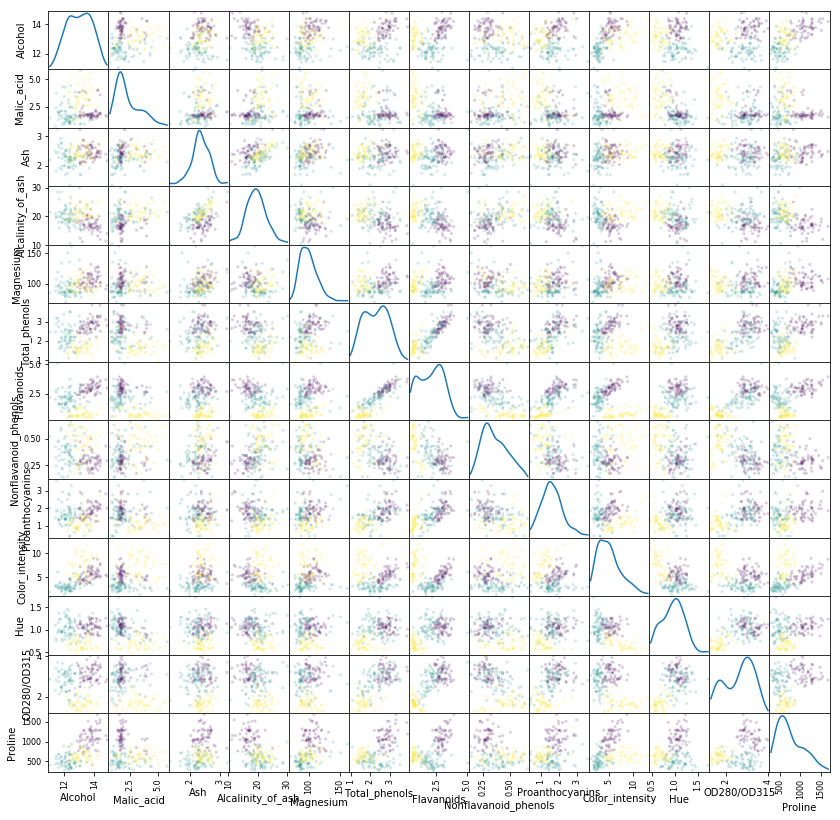

In [7]:
scatter_matrix(wine.loc[:,'Alcohol':'Proline'], 
               alpha=0.2, figsize=(14, 14), 
               diagonal='kde',marker='.',
               c=wine.Wine_type);

For this example let's practice a different call mode to lda(), using a formula; this is most useful
 when our data is in a dataframe format: 

In [8]:
lda_model = LinearDiscriminantAnalysis().fit(wine.loc[:,'Alcohol':'Proline'],
                                             wine.Wine_type)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=wine.columns[1:]
means
print('Coefs:')
coefs = pd.DataFrame(lda_model.scalings_)
coefs.index =wine.columns[1:]
coefs
print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

Priors: [0.33146067 0.3988764  0.26966292]
Means:



,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,13.745,2.011,2.456,17.037,106.339,2.840,2.982,0.290,1.899,5.528,1.062,3.158,1115.712
1,12.279,1.933,2.245,20.238,94.549,2.259,2.081,0.364,1.630,3.087,1.056,2.785,519.507
2,13.154,3.334,2.437,21.417,99.312,1.679,0.781,0.447,1.154,7.396,0.683,1.684,629.896


Coefs:


,0,1
Alcohol,-0.403,8.718e-01
Malic_acid,0.165,3.054e-01
Ash,-0.369,2.346e+00
Alcalinity_of_ash,0.155,-1.464e-01
Magnesium,-0.002,-4.628e-04
Total_phenols,0.618,-3.221e-02
Flavanoids,-1.661,-4.920e-01
Nonflavanoid_phenols,-1.496,-1.631e+00
Proanthocyanins,0.134,-3.071e-01
Color_intensity,0.355,2.532e-01


Explained Variance Ratio


,0
0,0.687
1,0.313


We can see that neither Magnesium or Proline seem useful to separate the wines; while
 Flavanoids and Nonflavanoid.phenols do. Ash is mainly used in the LD2.

Plot the projected data in the first two LDs

 We can see that the discrimination is very good

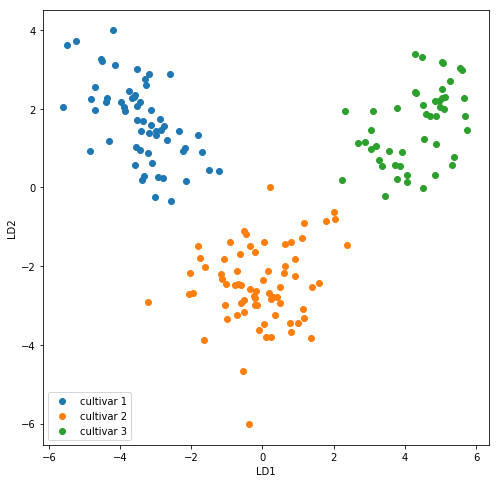

In [9]:
wine_trans = lda_model.transform(wine.loc[:,'Alcohol':'Proline'])
fig, ax = plt.subplots(figsize=(8,8))
for i in wine.Wine_type.unique():
    plt.scatter(wine_trans[:,0][wine.Wine_type==i],
                wine_trans[:,1][wine.Wine_type==i],
                label='cultivar %d'%i)
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
plt.legend();


 If need be, we can add the (projected) means to the plot

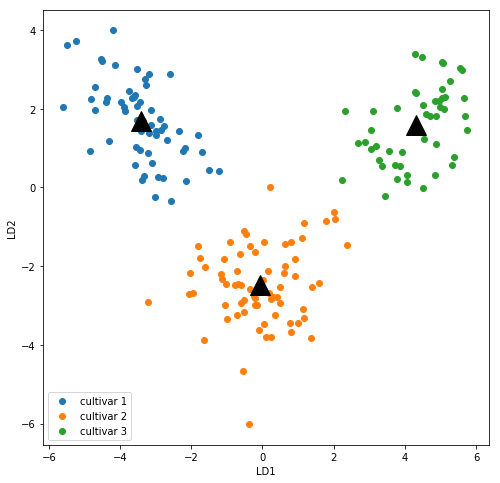

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
for i in wine.Wine_type.unique():
    plt.scatter(wine_trans[:,0][wine.Wine_type==i],
                wine_trans[:,1][wine.Wine_type==i],
                label='cultivar %d'%i)
    plt.plot(wine_trans[:,0][wine.Wine_type==i].mean(),
             wine_trans[:,1][wine.Wine_type==i].mean(),
             'k^',markersize=20)
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
plt.legend();

indeed classification is perfect

In [11]:
confusion(wine.Wine_type, lda_model.predict(wine.loc[:,'Alcohol':'Proline']), 
          classes=wine_classes)          

Predicted,cultivar 1,cultivar 2,cultivar 3
Actual,,,
cultivar 1,59,0,0
cultivar 2,0,71,0
cultivar 3,0,0,48


Let us switch to leave-one-out cross-validation

In [12]:
def loocv(X,y,model,classes):
    loo = LeaveOneOut()
    pred=[]
    for train_index, test_index in loo.split(X):
        X_tr, X_ts = X[train_index], X[test_index]
        y_tr, _ = y[train_index], y[test_index]
        model.fit(X_tr,y_tr)
        pred.append(model.predict(X_ts)[0])
    return confusion(y,pred,classes), 1-accuracy_score(y,pred)

In [13]:
cm, err = loocv(wine.loc[:,'Alcohol':'Proline'].values, 
                wine.Wine_type, 
                LinearDiscriminantAnalysis(),
                wine_classes)

cm

err*100

Predicted,cultivar 1,cultivar 2,cultivar 3
Actual,,,
cultivar 1,59,0,0
cultivar 2,1,69,1
cultivar 3,0,0,48


1.1235955056179803

2 mistakes (on 178 observations): 1.12% error

Quadratic Discriminant Analysis is the same

 problems may arise if for some class there are less (or equal) observations than dimensions
 (is not the case for the wine data)

In [14]:
qda_model = QuadraticDiscriminantAnalysis().fit(wine.loc[:,'Alcohol':'Proline'],
                                                wine.Wine_type)

print('Priors:\n')
pd.DataFrame(qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=wine.columns[1:]
means

Priors:



,0
0,0.331
1,0.399
2,0.270


Means:



,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,13.745,2.011,2.456,17.037,106.339,2.840,2.982,0.290,1.899,5.528,1.062,3.158,1115.712
1,12.279,1.933,2.245,20.238,94.549,2.259,2.081,0.364,1.630,3.087,1.056,2.785,519.507
2,13.154,3.334,2.437,21.417,99.312,1.679,0.781,0.447,1.154,7.396,0.683,1.684,629.896


 There is no projection this time (because projection is a linear operator and the QDA boundaries are quadratic ones)

 but let's have a look at classification:

In [15]:
confusion(wine.Wine_type, qda_model.predict(wine.loc[:,'Alcohol':'Proline']), 
          classes=wine_classes)

Predicted,cultivar 1,cultivar 2,cultivar 3
Actual,,,
cultivar 1,59,0,0
cultivar 2,1,70,0
cultivar 3,0,0,48


Let us switch to leave-one-out cross-validation

In [16]:
cm, err = loocv(wine.loc[:,'Alcohol':'Proline'].values,
                wine.Wine_type, 
                QuadraticDiscriminantAnalysis(),
                wine_classes)

cm

err*100

Predicted,cultivar 1,cultivar 2,cultivar 3
Actual,,,
cultivar 1,59,0,0
cultivar 2,1,70,0
cultivar 3,0,0,48


0.5617977528089901

1 mistake (on 178 observations): 0.56% error

 it would be nice to ascertain which wine is the "stubborn" one: it is a wine of type '2' classified
as class '1'. Maybe there is something special with this wine ...

 In the event of numerical errors (insufficient number of observations per class), we can use regularization.
 
 in this case the regularization parameter (0..1) is applied to the covariance matrix (Sigma) so it is not ill conditioned in this fashion
 
 `(1-reg_param)*Sigma + reg_param*np.eye(n_features)`

In [17]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1).\
                    fit(wine.loc[:,'Alcohol':'Proline'],
                        wine.Wine_type)

print('Priors:', qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=wine.columns[1:]
means

Priors: [0.33146067 0.3988764  0.26966292]
Means:



,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,13.745,2.011,2.456,17.037,106.339,2.840,2.982,0.290,1.899,5.528,1.062,3.158,1115.712
1,12.279,1.933,2.245,20.238,94.549,2.259,2.081,0.364,1.630,3.087,1.056,2.785,519.507
2,13.154,3.334,2.437,21.417,99.312,1.679,0.781,0.447,1.154,7.396,0.683,1.684,629.896


In [18]:
confusion(wine.Wine_type, qda_model.predict(wine.loc[:,'Alcohol':'Proline']), 
          classes=wine_classes)

Predicted,cultivar 1,cultivar 2,cultivar 3
Actual,,,
cultivar 1,59,0,0
cultivar 2,0,69,2
cultivar 3,0,0,48


***

## Example 2: The Naïve Bayes classifier

 Naive Bayes Classifier for Discrete Predictors: we use the 
 1984 United States Congressional Voting Records; 

 This data set includes votes for each of the U.S. House of Representatives Congressmen on 16 key votes
In origin they were nine different types of votes: 
     
* voted for, paired for, and announced for (these three simplified to yea or 'y'),
* voted against, paired against, and announced against (these three simplified to nay or 'n'), 
* voted present, voted present to avoid conflict of interest, and did not vote or otherwise make a position known 
     (these three simplified to an 'unknown' disposition)

 The goal is to classify Congressmen as Republican or Democrat as a function of their voting profiles,
which is not immediate because in the US Congressmen have a large freedom of vote 
 (obviously linked to their party but also to their own feelings, interests and compromises with voters)

In [19]:
HouseVotes84 = read_csv("house-votes-84.data", 
                        delimiter=',', 
                        header=None,na_values='?')
house_classes = ['n','y']

add meaningful names to the votes

In [20]:
HouseVotes84.columns=["Class","handicapped_infants","water_project_sharing",
                      "budget_resolution","physician_fee_freeze",
                      "el_salvador_aid","religious_groups_in_schools",
                      "anti_satellite_ban", "aid_to_nicaraguan_contras",
                      "mx_missile","immigration","synfuels_cutback",
                      "education_spending","superfund","crime",
                      "duty_free_exports","export_South_Africa"]
HouseVotes84.describe()

,Class,handicapped_infants,water_project_sharing,budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_cutback,education_spending,superfund,crime,duty_free_exports,export_South_Africa
count,435,423,387,424,424,420,424,421,420,413,428,414,404,410,418,407,331
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


In [21]:
for v in HouseVotes84.columns:
    HouseVotes84[v].value_counts(dropna=False)

democrat      267
republican    168
Name: Class, dtype: int64

n      236
y      187
NaN     12
Name: handicapped_infants, dtype: int64

y      195
n      192
NaN     48
Name: water_project_sharing, dtype: int64

y      253
n      171
NaN     11
Name: budget_resolution, dtype: int64

n      247
y      177
NaN     11
Name: physician_fee_freeze, dtype: int64

y      212
n      208
NaN     15
Name: el_salvador_aid, dtype: int64

y      272
n      152
NaN     11
Name: religious_groups_in_schools, dtype: int64

y      239
n      182
NaN     14
Name: anti_satellite_ban, dtype: int64

y      242
n      178
NaN     15
Name: aid_to_nicaraguan_contras, dtype: int64

y      207
n      206
NaN     22
Name: mx_missile, dtype: int64

y      216
n      212
NaN      7
Name: immigration, dtype: int64

n      264
y      150
NaN     21
Name: synfuels_cutback, dtype: int64

n      233
y      171
NaN     31
Name: education_spending, dtype: int64

y      209
n      201
NaN     25
Name: superfund, dtype: int64

y      248
n      170
NaN     17
Name: crime, dtype: int64

n      233
y      174
NaN     28
Name: duty_free_exports, dtype: int64

y      269
NaN    104
n       62
Name: export_South_Africa, dtype: int64

1 = democrat, 0 = republican
 Note "unknown dispositions" have been treated as missing values!

The naive bayes implementations of scikit-learn do not allow missing values and also need binary data, so we will preprocess first changing *y* for 1 and *n* for 0 and then we perform missing data imputation. Another option would be to eliminate all rows with missing, but that will discard half of the data

In [22]:
HouseVotes84.replace({'y':1, 'n':0},inplace=True)
HouseVotes84.head()

,Class,handicapped_infants,water_project_sharing,budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_cutback,education_spending,superfund,crime,duty_free_exports,export_South_Africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


We use the most frequent value from each column for imputation

In [23]:
HouseVotes84.loc[:,'handicapped_infants':] =  Imputer(strategy='most_frequent').\
                fit_transform(HouseVotes84.loc[:,'handicapped_infants':])
HouseVotes84.head()

,Class,handicapped_infants,water_project_sharing,budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_cutback,education_spending,superfund,crime,duty_free_exports,export_South_Africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [24]:
np.random.seed(1111)
N = HouseVotes84.shape[0]

 We first split the available data into learning and test sets, selecting randomly 2/3 and 1/3 of the data.
 
 We do this for a honest estimation of prediction performance

In [25]:
train, test = train_test_split(HouseVotes84, test_size=N//3)

We use the BernoulliNB estimator because we have binary data

In [26]:
model = BernoulliNB().fit(train.loc[:,'handicapped_infants':], 
                          train.Class)

To obtain the probabiblities from the model is a little bit tricky. 

The attribute `class_log_prior_` stores the priot log probabilities for the classes, so we can compute the probabilities doing:

In [27]:
np.e**model.class_log_prior_

array([0.62068966, 0.37931034])

For the attributes/class probabilities is trickier because ony one of the probabilities is stored (the othe is the complement) and also are the log probabilities

In [28]:
probs=pd.DataFrame({'Democrat Y':np.e**model.feature_log_prob_.T[:,0],
                    'Democrat N':1-np.e**model.feature_log_prob_.T[:,0],
                    'Republican Y':np.e**model.feature_log_prob_.T[:,1], 
                    'Republican N':1-np.e**model.feature_log_prob_.T[:,1]},
                    index=HouseVotes84.columns[1:])

probs

,Democrat Y,Democrat N,Republican Y,Republican N
handicapped_infants,0.533,0.467,0.205,0.795
water_project_sharing,0.549,0.451,0.518,0.482
budget_resolution,0.896,0.104,0.196,0.804
physician_fee_freeze,0.055,0.945,0.955,0.045
el_salvador_aid,0.236,0.764,0.929,0.071
religious_groups_in_schools,0.511,0.489,0.875,0.125
anti_satellite_ban,0.775,0.225,0.313,0.687
aid_to_nicaraguan_contras,0.835,0.165,0.259,0.741
mx_missile,0.797,0.203,0.170,0.830
immigration,0.505,0.495,0.545,0.455


predict the outcome of the first 20 Congressmen

In [29]:
model.predict(HouseVotes84.loc[0:20,'handicapped_infants':])

array(['republican', 'republican', 'republican', 'democrat', 'democrat',
       'republican', 'republican', 'republican', 'republican', 'democrat',
       'republican', 'republican', 'democrat', 'democrat', 'republican',
       'republican', 'democrat', 'democrat', 'republican', 'democrat',
       'democrat'], dtype='<U10')

In [30]:
pred=pd.DataFrame(model.predict_proba(HouseVotes84.loc[0:20,'handicapped_infants':]))

pred.columns=['democrat', 'republican']
pred

,democrat,republican
0,2.084e-07,1.000e+00
1,2.439e-07,1.000e+00
2,3.163e-02,9.684e-01
3,9.740e-01,2.604e-02
4,9.492e-01,5.077e-02
5,3.829e-01,6.171e-01
6,4.804e-05,1.000e+00
7,4.390e-06,1.000e+00
8,2.439e-07,1.000e+00
9,1.000e+00,7.242e-09


form and display confusion matrix & overall error

In [31]:
confusion(train.Class, model.predict(train.loc[:,'handicapped_infants':]), 
          classes=house_classes)

(1-accuracy_score(train.Class, 
                  model.predict(train.loc[:,'handicapped_infants':])))*100

Predicted,n,y
Actual,,
n,159,21
y,9,101


10.344827586206895

compute the test (prediction) error

In [32]:
confusion(test.Class,
          model.predict(test.loc[:,'handicapped_infants':]), 
          classes=house_classes)

(1-accuracy_score(test.Class,
                  model.predict(test.loc[:,'handicapped_infants':])))*100

Predicted,n,y
Actual,,
n,77,10
y,2,56


8.275862068965523

 note how most errors (10/12) correspond to democrats wrongly predicted as republicans

in the event of **empty empirical probabilities**, there is an alpha parameter (0-1) that can be use for performing Laplace correction (aka smoothing) (0 = no smoothing)

In [33]:
model = BernoulliNB(alpha=0.9).fit(train.loc[:,'handicapped_infants':], 
                                   train.Class)

***

## Example 3: The kNN classifier

We are going to use the famous (Fisher's or Anderson's) Iris data set, which gives the measurements in centimeters
of the sepal length and width and petal length and width, respectively, for 50 flowers from each of 3 species of Iris. 
 The species are Iris setosa, versicolor, and virginica.

In [34]:
np.random.seed(2)

iris_data, iris_labels = load_iris(return_X_y=True)
iris_names = ['setosa', 'versicolor', 'virginica']

 first we split a separate test set of relative size 30%

In [35]:
X_train, X_test, y_train, y_test = train_test_split(iris_data, 
                                                    iris_labels, 
                                                    test_size=0.3)

setup a kNN model with 3 neighbours
Notice there is no "learning" ... the data is the model (just test!)

In [36]:
myknn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
confusion(y_test, myknn.predict(X_test), classes=iris_names)

Predicted,setosa,versicolor,virginica
Actual,,,
setosa,17,0,0
versicolor,0,15,0
virginica,0,0,13


rows are predictions, columns are true test targets

 How do we optimize k? One way is by using LOOCV

In [37]:
cm, err = loocv(X_train,y_train,myknn, classes=iris_names)

cm

err*100

Predicted,setosa,versicolor,virginica
Actual,,,
setosa,33,0,0
versicolor,0,32,3
virginica,0,3,34


5.714285714285716

aha! now you see that previous training error (0%) was a little bit optimistic

 Let's loop over k

In [38]:
np.random.seed(4321)

errors = []
for i in range(1,int(np.sqrt(X_train.shape[0]))+1):
    myknn_cv = KNeighborsClassifier(n_neighbors=i)
    _, error = loocv(X_train,y_train,myknn_cv, classes=iris_names)
    errors.append(error)

pd.DataFrame({'K':range(1,int(np.sqrt(X_train.shape[0]))+1), 
              'LOOCV error':errors})


,K,LOOCV error
0,1,0.067
1,2,0.086
2,3,0.057
3,4,0.076
4,5,0.076
5,6,0.057
6,7,0.048
7,8,0.048
8,9,0.029
9,10,0.029


 It seems that k=9 is the best value.
 
Now we *refit* with k=9 and predict the test set

In [39]:
myknn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
confusion(y_test, myknn.predict(X_test), classes=iris_names)
(1-accuracy_score(y_test, myknn.predict(X_test)))*100

Predicted,setosa,versicolor,virginica
Actual,,,
setosa,17,0,0
versicolor,0,14,1
virginica,0,0,13


2.2222222222222254

so our error is 2.2%

***

## Example 4: Logistic Regression using artificial data

The goal of this example is to get acquainted with the call to glm()
 glm() is used to fit generalized linear models (of which both linear and logistic regression are particular cases)

 You may need to recall at this point the logistic regression model ...

 Let $x$ represent a single continuous predictor
 
 Let $y$ represent a class ('0' or '1'), with a probability of being 1 that is related linearly to the predictor
 via the logit funtion, that is $logit(p) = a*x + b$ (or $beta_1*x + beta_0$ if you prefer)

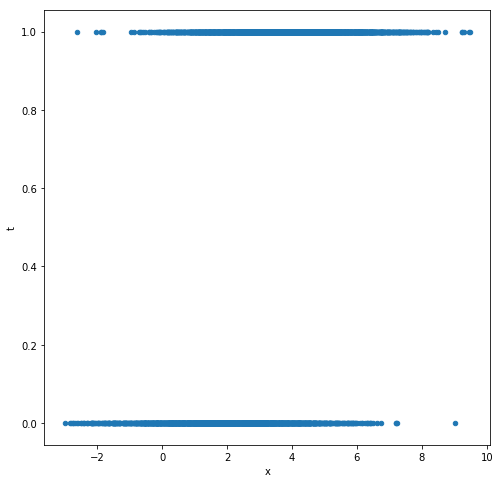

In [40]:
np.random.seed(1968)

N = 4000
x = normal (3,2,N)  # generate the x_n 

a = 0.6 
b = -1.5 # this is the ground truth, which is unknown

p = 1/(1+np.exp( -(a*x + b) )) # generate the p_n 
t = binomial(1,p, N)  # generate the targets according to p
data = pd.DataFrame({'x':x, 't':t})

data.plot.scatter('x','t',figsize=(8,8));

In [41]:
model = GLM.from_formula('t ~ x', data, family=Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      t   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2248.1
Date:                Thu, 06 Sep 2018   Deviance:                       4496.1
Time:                        14:32:49   Pearson chi2:                 3.99e+03
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5217      0.075    -20.278      0.000      -1.669      -1.375
x              0.6040      0.023     26.463      0.000       0.559       0.649
==============================================================================
"""

 Obviously x is very significant (and the Intercept is always significant)

Therefore, our estimated model is
 $logit(p_n) ={{result.params[1]}}*x_n {{result.params[0]}}
 quite close to the ground truth

 In general you get this as:
 
  result.params

Interpretation of the coefficients:
 
- For a 1 unit increase in x, there is an increase in the odds for t by a factor of ...

In [42]:
result.params

Intercept   -1.522
x            0.604
dtype: float64

In [43]:
np.exp(result.params[1])

1.8293462220130607

 that is almost doubling the odds (~82% more)

***

## Example 5: Logistic regression for classifying spam mail

 This example will also illustrate how to change the 'cut point' for prediction, when there is an 
 interest in minimizing a particular source of errors

In [44]:
spam = read_csv("spambase.data", delimiter=',', header=None)
file = open('spambase.names', 'r')
spam.columns = [n.strip() for n in file.readlines()]

spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We do some basic pre-processing

In [45]:
spam.loc[:,'capital_run_length_average':'capital_run_length_total'] =\
        spam.loc[:,'capital_run_length_average':'capital_run_length_total'].\
                    apply(lambda x: np.log10(x+1))
spam = spam[spam.word_freq_george==0]
spam = spam[spam.word_freq_650==0]
spam = spam[spam.word_freq_hp==0]
spam = spam[spam.word_freq_hpl==0]
spam =spam.drop(columns=['word_freq_george','word_freq_650',
                         'word_freq_hp','word_freq_hpl'])
spam['about_money']=spam.word_freq_free+spam.word_freq_business+\
spam.word_freq_credit+spam.word_freq_money
spam=spam.drop(columns=['word_freq_free','word_freq_business',
                        'word_freq_credit','word_freq_money'])
Class = spam.Class   # move the Class column to the last position
spam=spam.drop(columns=['Class'])
spam['Class'] = Class

spam.shape


(2999, 51)

In [46]:
np.random.seed(4321)
train, test = train_test_split(spam, test_size=0.33)


Fit a GLM in the learning data

In [47]:
spamM1 = GLM(train.Class,
             add_constant(train.loc[:,:'about_money']), 
             family=Binomial())
resultM1 = spamM1.fit()
resultM1.summary()

/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/links.py:167: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib64/python3.6/site-packages/statsmodels/genmod/families/family.py:932: Runtim

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:                 2009
Model:                            GLM   Df Residuals:                     1958
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 06 Sep 2018   Deviance:                          nan
Time:                        14:32:54   Pearson chi2:                 2.24e+04
No. Iterations:                   100   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.0624      0.464    -10.904      0.000      -5.972      -4.152
word_freq_make                -0.1299      0.293     -0.443      0.658      -0.705       0.445
word_freq_address             -0.1619      0.131     -1.239      0.216      -0.418       0.094
word_freq_all                 -0.0884      0.167     -0.531      0.595      -0.415       0.238
word_freq_3d                 350.6953    8.8e+05      0.000      1.000   -1.73e+06    1.73e+06
word_freq_our                  0.5344      0.120      4.464      0.000       0.300       0.769
word_freq_over                 0.6943      0.353      1.965      0.049       0.002       1.387
word_freq_remove               1.6118      0.329      4.895      0.000       0.966       2.257
word_freq_internet             0.5349      0.148      3.621      0.000       0.245       0.824
word_freq_order               -0.1082      0.304     -0.356      0.722      -0.703       0.487
word_freq_mail                 0.0561      0.090      0.625      0.532      -0.120       0.232
word_freq_receive             -0.5076      0.380     -1.334      0.182      -1.253       0.238
word_freq_will                -0.1398      0.107     -1.308      0.191      -0.349       0.070
word_freq_people              -0.0531      0.334     -0.159      0.874      -0.708       0.602
word_freq_report               0.0120      0.307      0.039      0.969      -0.590       0.614
word_freq_addresses            0.8487      0.802      1.058      0.290      -0.724       2.421
word_freq_email                0.1439      0.147      0.978      0.328      -0.144       0.432
word_freq_you                  0.1415      0.051      2.782      0.005       0.042       0.241
word_freq_your                 0.1381      0.074      1.870      0.061      -0.007       0.283
word_freq_font                 0.1757      0.279      0.630      0.529      -0.371       0.722
word_freq_000                  1.0192      0.468      2.176      0.030       0.101       1.937
word_freq_lab                -12.4533     10.458     -1.191      0.234     -32.950       8.044
word_freq_labs                -1.6974      1.046     -1.623      0.105      -3.748       0.353
word_freq_telnet              -0.2793      1.874     -0.149      0.882      -3.952       3.394
word_freq_857                 -0.5357      3.463     -0.155      0.877      -7.323       6.252
word_freq_data                -0.4946      0.292     -1.696      0.090      -1.066       0.077
word_freq_415                424.0571   4.52e+07   9.38e-06      1.000   -8.86e+07    8.86e+07
word_freq_85                  -1.8880      1.518     -1.244      0.214      -4.863       1.087
word_freq_technology           0.8304      0.547      1.519      0.129      -0.241       1.902
word_freq_1999                 0.2841      0.237      1.197      0.231      -0.181       0.749
word_freq_parts            

We can see that there are some variables that have small weights and are probably not very relevant. The R notebook uses stepwise variable selection to simplify the model.

Statsmodels does not have stepwise variable selection, but we can use crossvalidated Recursive Forward Elimination (RFE) with the implementation of logistic regression from scikit learn. RFE does the same thing as stepwise variable selection but uses accuracy to select the best model using cross validation. The implentation of logistic regression in scikit-learn is more sofisticated and uses regularization so the results will be different than in the R notebook.

In [48]:
# we use L1 regularization to make 0 a large number 
# of the weigths, the lower the C the more attributes will be discarded
logreg = LogisticRegression(solver='liblinear',penalty='l1',C=1)
#njobs = -1 means that all the cores from the CPU are used
rfe = RFECV(estimator=logreg,cv=10,n_jobs=-1) 
rfe.fit(train.loc[:,:'about_money'],train.Class);

In [49]:
print('Features Selected:',rfe.n_features_)
print('\n Ranking of features')
sel = pd.DataFrame({'features': train.columns[:-1],
                    'ranking': rfe.ranking_, 
                    'selected':rfe.support_})
sel.sort_values(by='ranking')

Features Selected: 38

 Ranking of features


,features,ranking,selected
24,word_freq_data,1,True
27,word_freq_technology,1,True
28,word_freq_1999,1,True
30,word_freq_pm,1,True
31,word_freq_direct,1,True
32,word_freq_cs,1,True
33,word_freq_meeting,1,True
34,word_freq_original,1,True
35,word_freq_project,1,True
26,word_freq_85,1,True


We get the extimator from the RFE and the list of selected variable to slice the data matrix

In [50]:
resultM1 = rfe.estimator_
sel_features = list(sel.features[sel.selected])
sel_features


['word_freq_address',
 'word_freq_3d',
 'word_freq_our',
 'word_freq_over',
 'word_freq_remove',
 'word_freq_internet',
 'word_freq_receive',
 'word_freq_will',
 'word_freq_addresses',
 'word_freq_email',
 'word_freq_you',
 'word_freq_your',
 'word_freq_font',
 'word_freq_000',
 'word_freq_lab',
 'word_freq_labs',
 'word_freq_data',
 'word_freq_85',
 'word_freq_technology',
 'word_freq_1999',
 'word_freq_pm',
 'word_freq_direct',
 'word_freq_cs',
 'word_freq_meeting',
 'word_freq_original',
 'word_freq_project',
 'word_freq_re',
 'word_freq_edu',
 'word_freq_conference',
 'char_freq_;',
 'char_freq_(',
 'char_freq_!',
 'char_freq_$',
 'char_freq_#',
 'capital_run_length_average',
 'capital_run_length_longest',
 'capital_run_length_total',
 'about_money']

 We define now a convenience function:

 'P' is a parameter; whenever our filter assigns spam with probability at least P then we predict spam

In [51]:
def spam_acc(P=0.5):
    # We use predict_proba instead of prediction to obtain 
    # the probabilities of the classes and 
    # we select only the probability for class 1 as 
    # the other is just the complementary
    
    # Accuracy in training
    pred = resultM1.predict_proba(train.loc[:,sel_features])[:,1]
    lab_tr = [1 if i>=P else 0 for i in pred]
    df_tr=confusion(train.Class,lab_tr, classes=['nospam','spam'])

    # Accuracy in test
    pred = resultM1.predict_proba(test.loc[:,sel_features])[:,1]
    lab_ts = [1 if i>=P else 0 for i in pred]
    df_ts=confusion(test.Class,lab_ts, classes=['nospam','spam'])
 
    return df_tr, (1-accuracy_score(train.Class,lab_tr))*100,\
           df_ts, (1-accuracy_score(test.Class,lab_ts))*100

In [52]:
c_tr,e_tr,c_ts,e_ts= spam_acc()
c_tr
print(f'Training error: {e_tr}%')
c_ts
print(f'Test error: {e_ts}%')

Predicted,nospam,spam
Actual,,
nospam,759,90
spam,67,1093


Training error: 7.81483325037332%


Predicted,nospam,spam
Actual,,
nospam,382,41
spam,32,535


Test error: 7.373737373737377%


 Although the errors are quite low still one could argue that we should try to lower the probability of predicting spam when it is not
 We can do this (at the expense of increasing the converse probability) by:

In [53]:
c_tr,e_tr,c_ts,e_ts= spam_acc(0.7)
c_tr
print(f'Training error: {e_tr}%')
c_ts
print(f'Test error: {e_ts}%')

Predicted,nospam,spam
Actual,,
nospam,801,48
spam,156,1004


Training error: 10.154305624688897%


Predicted,nospam,spam
Actual,,
nospam,403,20
spam,78,489


Test error: 9.898989898989896%


 So we get a much better spam filter; notice that the filter has a very low probability of 
predicting spam when it is not (which is the delicate case), of about 

In [54]:
c_ts.loc['nospam','spam'] /c_ts.loc['nospam'].sum()*100

4.7281323877068555